# **Projecton**
## **MiddleOut Job Interview Project**
Dmitry Gribovsky 317088573

In [53]:
# imports

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile

In [2]:
lr = 0.001
batch_size = 100
epochs = 10

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device == 'cuda':
  torch.cuda.manual_seed_all(1234)

print(device)

cuda


# Preparing The Data
In this part I am going to prepare the database - I'm going to be using 2 different datasets:
* The first is specifically dog and cat images which are from a Kaggle Competition called **Dogs vs Cats.**
* The seconds is just random images from a dataset called **STL-10.**

Because the random images also contain dogs and cats it is going to impact score and learning rate a bit but for now i'll estimate that there are few enough of them to not have a great impact. Because we need an even ratio between the classes for a good model training, I am going to 'cut' the classified images into 3 even groups and merge them into a single new dataset.

In [4]:
# connecting google drive

from google.colab import drive, files
drive.mount('/content/gdrive')
root_path = 'gdrive/MyDrive/Projecton/'

# get Kaggle for datasets

files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

Mounted at /content/gdrive


Saving kaggle.json to kaggle.json
kaggle.json


In [5]:
# obtain the datasets
!kaggle competitions download -c dogs-vs-cats
!kaggle datasets download -d jessicali9530/stl10

100% 812M/812M [00:04<00:00, 143MB/s]
100% 812M/812M [00:04<00:00, 183MB/s]
 99% 1.86G/1.88G [00:18<00:00, 185MB/s]
100% 1.88G/1.88G [00:18<00:00, 111MB/s]


In [6]:
# create local directories
base_dir = '../content/Projecton/'
os.makedirs(base_dir + 'dogs_cats', exist_ok=True)
os.makedirs(base_dir + 'rando', exist_ok=True)

In [7]:
# Dogs-Cats unzip
with zipfile.ZipFile('../content/dogs-vs-cats.zip') as dogscats:
  dogscats.extractall(base_dir + 'dogs_cats')

with zipfile.ZipFile(base_dir + 'dogs_cats/train.zip') as train:
  train.extractall(base_dir + 'dogs_cats')

with zipfile.ZipFile(base_dir + 'dogs_cats/test1.zip') as test:
  test.extractall(base_dir + 'dogs_cats')

# stl10 unzip
with zipfile.ZipFile('../content/stl10.zip') as rando:
  rando.extractall(base_dir + 'rando')

In [8]:
# lets confirm that we got the right images and paths

print('Dogs Cats:')
print(os.listdir(base_dir + 'dogs_cats/train')[:5])

print('Rando:')
print(os.listdir(base_dir + 'rando/train_images')[:5])

Dogs Cats:
['cat.1995.jpg', 'dog.7484.jpg', 'cat.6161.jpg', 'dog.12283.jpg', 'cat.6703.jpg']
Rando:
['train_image_png_3871.png', 'train_image_png_4387.png', 'train_image_png_980.png', 'train_image_png_3419.png', 'train_image_png_4642.png']


In [9]:
import glob

train_list = glob.glob(os.path.join(base_dir + 'dogs_cats/train', '*.jpg'))
train_list += glob.glob(os.path.join(base_dir + 'rando/train_images', '*.png'))

# lets give an approximately even amout from each class in the test group
test_list = glob.glob(os.path.join(base_dir + 'dogs_cats/test1', '*.jpg'))
test_list = test_list[0:5000]
test_list += glob.glob(os.path.join(base_dir + 'rando/test_images', '*.png'))[0:2500]

In [71]:
print(len(train_list), len(test_list))

30000 7500


There are 5000 random images in the train folder so we are going to take 5000 cats and dogs accordingly to even out the amounts of the final train datasets.

In [11]:
# print path names of different images to get an idea of the format
print(train_list[0])
print(train_list[-1])

../content/Projecton/dogs_cats/train/cat.1995.jpg
../content/Projecton/rando/train_images/train_image_png_3323.png


In [70]:
# split into even categories

even_train = []
c1, c2, c3 = 5000, 5000, 5000     # seperate counters for each class

for path in train_list:
  # classify image
  category = path.split('/')[-1].split('.')[0]
  if category == 'cat' and c1 > 0:
    even_train.append(path)
    c1 -= 1
  elif category == 'dog' and c2 > 0:
    even_train.append(path)
    c2 -= 1
  elif category not in ('cat', 'dog') and c3 > 0:
    even_train.append(path)
    c3 -= 1

In [90]:
print(f'New Train size: {len(even_train)}')
print(f'Sample: {even_train[0]}')

New Train size: 12000
Sample: ../content/Projecton/dogs_cats/train/cat.9712.jpg


Now we can also showcase some images from our new dataset to show variability in both size and classes.

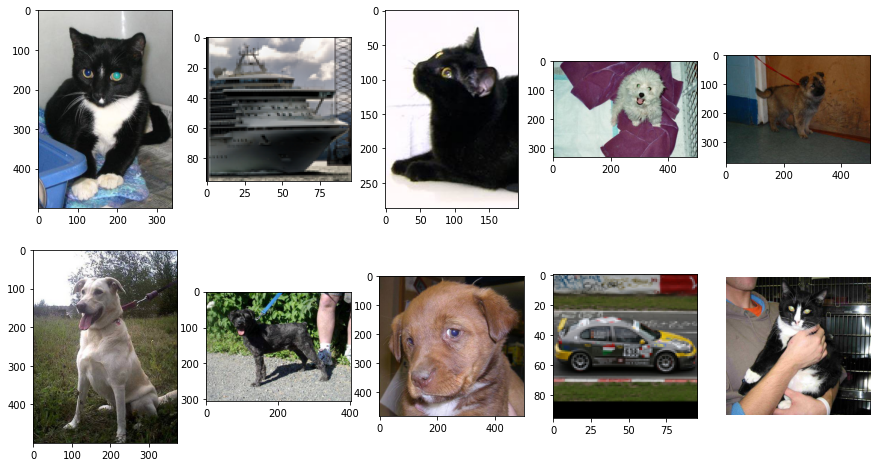

In [74]:
from PIL import Image
random_idx = np.random.randint(1, len(even_train), size=10)

fig = plt.figure(figsize=(15, 8))
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(even_train[idx])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

Lets create a dataset class for loading the images from the directory.

In [75]:
class dataset(torch.utils.data.Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
        

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength


    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
        else:
            label = 2
            
        return (img_transformed, label)

Now lets create some transformers for data augmentation, we'll also add a randomcrop function for image variability in case of overfitting.

Then we are going to prepare the dataloaders from the new dataset for the learning phase.

In [76]:
#data Augumentation
train_transforms =  transforms.Compose([
      transforms.Resize((224, 224)),
      # transforms.RandomResizedCrop(224),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
      transforms.Resize((224, 224)),
      # transforms.RandomResizedCrop(224),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
    ])


test_transforms = transforms.Compose([   
      transforms.Resize((224, 224)),
      #  transforms.RandomResizedCrop(224),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor()
    ])

from sklearn.model_selection import train_test_split
even_train, val_list = train_test_split(even_train, test_size=0.2)

train_data = dataset(even_train, transform = train_transforms)
val_data = dataset(val_list, transform = val_transforms)
test_data = dataset(test_list, transform = test_transforms)

train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(dataset = val_data, batch_size = batch_size, shuffle = True)

Now I am going to create the CNN model, I am going to keep it simple and use a classic convolutional model with some minor tweaks for multi-channeled input for the RGB of the image.

In [77]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )   
        
        self.fc1 = nn.Linear(3*3*64,10)
        # self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(10, 3)
        self.relu = nn.ReLU()
        
        self._initialize_weights()
              
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        # out = self.dropout(out)
        out = self.fc2(out)
        return out


    def _initialize_weights(self):
      nn.init.orthogonal_(self.layer1[0].weight, nn.init.calculate_gain('relu'))
      nn.init.orthogonal_(self.layer2[0].weight, nn.init.calculate_gain('relu'))
      nn.init.orthogonal_(self.layer3[0].weight, nn.init.calculate_gain('relu'))

In [78]:
# connect the model to the gpu (hopefully if google lets us) and then display the model to verify that everything is in order
model = Cnn().to(device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU()
)

Here aswell I am going to use the classic Adam and MCCE

In [79]:
optimizer = optim.Adam(params = model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()

Let the training begin 💪

In [80]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        
        output = model(data)
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
        
    with torch.no_grad():
        epoch_val_accuracy=0
        epoch_val_loss = 0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)
            
            val_output = model(data)
            val_loss = criterion(val_output,label)
            
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc / len(val_loader)
            epoch_val_loss += val_loss / len(val_loader)
            
        print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))

Epoch : 1, train accuracy : 0.6540002226829529, train loss : 0.7216049432754517
Epoch : 1, val_accuracy : 0.7549999952316284, val_loss : 0.5273128151893616
Epoch : 2, train accuracy : 0.7761668562889099, train loss : 0.4847433865070343
Epoch : 2, val_accuracy : 0.7993333339691162, val_loss : 0.45002156496047974
Epoch : 3, train accuracy : 0.8128334879875183, train loss : 0.4250417649745941
Epoch : 3, val_accuracy : 0.7856666445732117, val_loss : 0.45288532972335815
Epoch : 4, train accuracy : 0.8266668319702148, train loss : 0.39765509963035583
Epoch : 4, val_accuracy : 0.813666582107544, val_loss : 0.4188731908798218
Epoch : 5, train accuracy : 0.8428336381912231, train loss : 0.3671540915966034
Epoch : 5, val_accuracy : 0.8173332810401917, val_loss : 0.4041755795478821
Epoch : 6, train accuracy : 0.8554167747497559, train loss : 0.338660329580307
Epoch : 6, val_accuracy : 0.8296666145324707, val_loss : 0.38966771960258484
Epoch : 7, train accuracy : 0.8598334193229675, train loss : 0

### Verdict #1
So after testing a few CNN models:
* Dropout 0.5, 0.2
* Image cropping variation with / without
* Learning rates of 0.001, 0.005, 0.01

I've found that the following are the optimal for the time of writing:
No dropout, learning rate of 0.5e-3, unaugmented images.

[  ] I'll start playing and exploring parameters if the needed score will be more than 80%.

---

Now lets write a function to test out the model's predictions and also visualize them.

In [180]:
def predict(model, data):
  res = model(data.to(device))
  pred = F.softmax(res, dim=1)
  return [np.argmax(x.detach().cpu().numpy()) for x in pred]

def draw_predict(model, data):
  preds = predict(model, data) # predict labels

  # plot test images with labels
  counter = 1
  dim = 5
  plt.figure(figsize=(18,18))
  for x in range(dim**2):
    plt.subplot(dim, dim, counter)
    counter += 1
    img = data[x]
    img = img.moveaxis(0, 1)
    img = img.moveaxis(1, 2)
    plt.imshow(img)
    
    # define title
    if preds[x] == 0:
      res = 'cat'
    elif preds[x] == 1:
      res = 'dog'
    else:
      res = 'other'
    plt.title(res)

  plt.show()

Lets validate the F1 score on a random batch.

In [192]:
import sklearn.metrics as met
data = next(iter(train_loader))
met.f1_score(predict(model, data[0]), data[1], average=None)

array([0.86486486, 0.84848485, 0.96666667])

Seems pretty good an coherent with our accuracies during training.

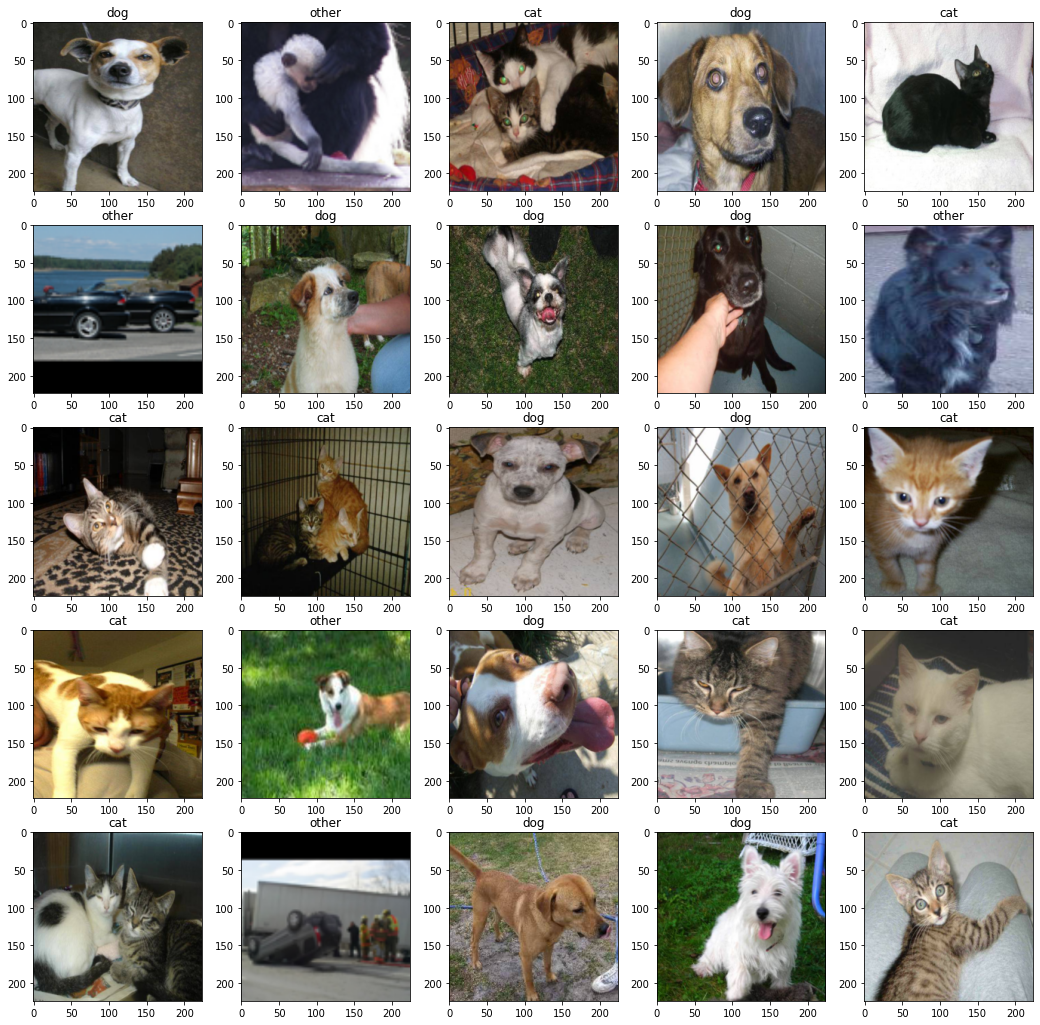

In [184]:
draw_predict(model, next(iter(test_loader))[0])